# Part 1 - WebScraping in Wikipedia page 
### looking for Postal Codes in Canada 

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import geopy
import json
import urllib.request
import unidecode

1. Get the HTML page of Wikipedia
2. Using read_html to convert the html data into list of Data frame objects
3. Remove cells which have borrow not assigned.

In [2]:
page = 'https://pt.wikipedia.org/wiki/Lista_dos_distritos_de_S%C3%A3o_Paulo_por_popula%C3%A7%C3%A3o'
wiki = pd.read_html(page)
df = wiki[1]
df.drop(columns = ["Posição", "População 2010", "Unnamed: 3"], inplace=True, index = None)
df.dropna(axis = 0, inplace = True)
df = df.rename(columns={'Distrito': 'District'})
df.head()

,District
0,Grajaú
1,Jardim Ângela
2,Sapopemba
3,Capão Redondo
4,Jardim São Luís


In [3]:
#checking if Postal Code has unique values
unique = len(df['District'].unique()) == len(df['District'])
print("Number of Unique Districts = Total Districs? Answer:", unique)

Number of Unique Districts = Total Districs? Answer: True


In [4]:
df

,District
0,Grajaú
1,Jardim Ângela
2,Sapopemba
3,Capão Redondo
4,Jardim São Luís
...,...
91,Jaguara
92,Sé
93,Pari
94,Barra Funda


# Part 2 - Geocoding the districts found

### The code below is used to get the latitude and longitude data on all Districts from São Paulo, from the Geocode.Earth API:

In [5]:
def GetCoord(x):
    distrito = x['District']
    #distrito = 'Bairro ' + distrito + ' , São Paulo , Estado de São Paulo, Brasil'
    distrito = distrito.replace(" ","%2C+")
    distrito = unidecode.unidecode(distrito)

    api_key = 'ge-851d9bd09dce02ba'
    query = "https://api.geocode.earth/v1/search?" \
            "api_key=" + api_key + "&"\
            "boundary.gid=whosonfirst:locality:102062255&" \
            "text=" +  distrito

    response = json.load(urllib.request.urlopen(query))
    lat = response['features'][0]['geometry']['coordinates'][1]
    lon = response['features'][0]['geometry']['coordinates'][0]
    
    return lat, lon
    
df[['latitude','longitude']] = df.apply(GetCoord, axis=1, result_type="expand")
df

,District,latitude,longitude
0,Grajaú,-23.765150,-46.695327
1,Jardim Ângela,-23.720471,-46.771372
2,Sapopemba,-23.605114,-46.509945
3,Capão Redondo,-23.665079,-46.780830
4,Jardim São Luís,-23.657646,-46.730065
...,...,...,...
91,Jaguara,-23.501534,-46.736998
92,Sé,-23.547955,-46.634940
93,Pari,-23.527765,-46.624292
94,Barra Funda,-23.525198,-46.669709


In [6]:
# df.to_csv("Distritos_Lat_Long.csv", encoding='utf-8', index = False)

# Part 3 - Clustering the Districts in São Paulo
#### Clustering São Paulo based on the similarities of the venues categories using Kmeans and Foursquare API

#### Creating a map of Districts in São Paulo

In [7]:
import folium
# maping SP using latitude and longitude
map_SP = folium.Map(location=[df['latitude'].mean(), df['longitude'].mean()], zoom_start=11)
# add markers to map
for lat, lng, neighborhood in zip(df['latitude'], df['longitude'], df['District']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        ).add_to(map_SP)  
    
map_SP

### Getting data from Foursquare 

In [8]:
#Foursquare API's ID and Secret:
CLIENT_ID = 'ICENRPENHI5COLTSXYLVNA20ROAVOHVR0BV0PQWNXML3K0AI'
CLIENT_SECRET = 'RX3WQ1S1YXNZGZUIB40KP0QCLIW0BDCOVY4XAI1K2DJ4FFKQ'
VERSION = '20180604' # API version

def getAPI_URL(latitude, longitude):
    LIMIT = 300
    radius = 1000
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
        CLIENT_ID, 
        CLIENT_SECRET, 
        VERSION, 
        latitude, 
        longitude, 
        radius, 
        LIMIT)

    return url

In [9]:
neighborhood_latitude = df.loc[0, 'latitude'] # neighborhood latitude value
neighborhood_longitude = df.loc[0, 'longitude'] # neighborhood longitude value

url = getAPI_URL(neighborhood_latitude, neighborhood_longitude)
url

'https://api.foursquare.com/v2/venues/explore?&client_id=ICENRPENHI5COLTSXYLVNA20ROAVOHVR0BV0PQWNXML3K0AI&client_secret=RX3WQ1S1YXNZGZUIB40KP0QCLIW0BDCOVY4XAI1K2DJ4FFKQ&v=20180604&ll=-23.76515,-46.695327&radius=1000&limit=300'

In [10]:
results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '604eddbaabd42f5c85ba5571'},
 'response': {'headerLocation': 'Grajaú',
  'headerFullLocation': 'Grajaú, São Paulo',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 21,
  'suggestedBounds': {'ne': {'lat': -23.75614999099999,
    'lng': -46.68551148827761},
   'sw': {'lat': -23.774150009000007, 'lng': -46.705142511722386}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4fa91986e4b09ce1657e1101',
       'name': 'Padaria Laranjeira',
       'location': {'address': 'Antônio Carlos Benjamin Dos Santos',
        'crossStreet': 'Av',
        'lat': -23.768121183078673,
        'lng': -46.69505254621754,
        'labeledLatLngs': [{'label': 'display',
          'lat': -23.768121183078673,
          'lng': -46.69505254621754}]

#### The table of venues returned has a json object for each venue, as shown below:
##### 1. Table of venues - see that column categories has a json for each row!

In [11]:
import json
from pandas import json_normalize

venues = results['response']['groups'][0]['items']
    
nearby_venues = json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues = nearby_venues.loc[:, filtered_columns]
nearby_venues

,venue.name,venue.categories,venue.location.lat,venue.location.lng
0,Padaria Laranjeira,"[{'id': '4bf58dd8d48988d16a941735', 'name': 'B...",-23.768121,-46.695053
1,Point do Açaí,"[{'id': '4bf58dd8d48988d1c9941735', 'name': 'I...",-23.767923,-46.697741
2,Dona Ana - Hotdog,"[{'id': '4bf58dd8d48988d147941735', 'name': 'D...",-23.761539,-46.701958
3,Pizzaria Campanhole,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",-23.768466,-46.697278
4,Bar e Restaurante Portugal - Bar Do Ivan,"[{'id': '4bf58dd8d48988d16e941735', 'name': 'F...",-23.763049,-46.702797
5,Academia Absolut Fitness,"[{'id': '4bf58dd8d48988d175941735', 'name': 'G...",-23.763770,-46.696196
6,Jardim Itajaí,"[{'id': '4bf58dd8d48988d104951735', 'name': 'B...",-23.763506,-46.687058
7,Pizzaria Tropical I,"[{'id': '4bf58dd8d48988d1ca941735', 'name': 'P...",-23.763443,-46.695964
8,Praça do Jardim Myrna (Perto do Levi),"[{'id': '4bf58dd8d48988d163941735', 'name': 'P...",-23.767991,-46.695194
9,Ricoy Supermercados,"[{'id': '4bf58dd8d48988d118951735', 'name': 'G...",-23.767467,-46.698228


##### 2. The Json contained in each row of column "venue.categories", converted to dataframe

In [12]:
cat1= pd.DataFrame()
for row in range(len(nearby_venues)):
    cat1 = cat1.append(json_normalize(nearby_venues['venue.categories'][row]), ignore_index=True)
cat1

,id,name,pluralName,shortName,primary,icon.prefix,icon.suffix
0,4bf58dd8d48988d16a941735,Bakery,Bakeries,Bakery,True,https://ss3.4sqi.net/img/categories_v2/food/ba...,.png
1,4bf58dd8d48988d1c9941735,Ice Cream Shop,Ice Cream Shops,Ice Cream,True,https://ss3.4sqi.net/img/categories_v2/food/ic...,.png
2,4bf58dd8d48988d147941735,Diner,Diners,Diner,True,https://ss3.4sqi.net/img/categories_v2/food/di...,.png
3,4bf58dd8d48988d1ca941735,Pizza Place,Pizza Places,Pizza,True,https://ss3.4sqi.net/img/categories_v2/food/pi...,.png
4,4bf58dd8d48988d16e941735,Fast Food Restaurant,Fast Food Restaurants,Fast Food,True,https://ss3.4sqi.net/img/categories_v2/food/fa...,.png
5,4bf58dd8d48988d175941735,Gym / Fitness Center,Gyms or Fitness Centers,Gym / Fitness,True,https://ss3.4sqi.net/img/categories_v2/buildin...,.png
6,4bf58dd8d48988d104951735,Boutique,Boutiques,Boutique,True,https://ss3.4sqi.net/img/categories_v2/shops/a...,.png
7,4bf58dd8d48988d1ca941735,Pizza Place,Pizza Places,Pizza,True,https://ss3.4sqi.net/img/categories_v2/food/pi...,.png
8,4bf58dd8d48988d163941735,Park,Parks,Park,True,https://ss3.4sqi.net/img/categories_v2/parks_o...,.png
9,4bf58dd8d48988d118951735,Grocery Store,Grocery Stores,Grocery Store,True,https://ss3.4sqi.net/img/categories_v2/shops/f...,.png


##### 3. Now, we are going to get only the NAME of VENUE from each Json and put it in the column "categories"

In [13]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']
    
# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns names
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Padaria Laranjeira,Bakery,-23.768121,-46.695053
1,Point do Açaí,Ice Cream Shop,-23.767923,-46.697741
2,Dona Ana - Hotdog,Diner,-23.761539,-46.701958
3,Pizzaria Campanhole,Pizza Place,-23.768466,-46.697278
4,Bar e Restaurante Portugal - Bar Do Ivan,Fast Food Restaurant,-23.763049,-46.702797


### Now that we validated the API response and managed to make bring it in a dataframe, let's make a function that gets responses for the entire Database of locations in São Paulo:

In [14]:
def getNearbyVenues(names, latitudes, longitudes, radius=1000):
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        #print(name1)            
        # create the API request URL
        url = getAPI_URL(lat, lng)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venues_list in venues_list for item in venues_list])
    nearby_venues.columns = ['District', 
                  'District Latitude', 
                  'District Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Let's run it with São Paulo's Zip Codes

In [15]:
sp_venues = getNearbyVenues(df['District'],df['latitude'],df['longitude'])

#### In return, we now have a dataset with venues

In [16]:
print(sp_venues.shape)
sp_venues.head()

(5767, 7)


,District,District Latitude,District Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Grajaú,-23.76515,-46.695327,Padaria Laranjeira,-23.768121,-46.695053,Bakery
1,Grajaú,-23.76515,-46.695327,Point do Açaí,-23.767923,-46.697741,Ice Cream Shop
2,Grajaú,-23.76515,-46.695327,Dona Ana - Hotdog,-23.761539,-46.701958,Diner
3,Grajaú,-23.76515,-46.695327,Pizzaria Campanhole,-23.768466,-46.697278,Pizza Place
4,Grajaú,-23.76515,-46.695327,Bar e Restaurante Portugal - Bar Do Ivan,-23.763049,-46.702797,Fast Food Restaurant


#### Checking how many categories and how many venues we can find

In [17]:
sp_venues['Venue Category'].nunique()

369

In [18]:
# one hot encoding
Grouped_Venues = pd.get_dummies(sp_venues[['Venue Category']], prefix="", prefix_sep="")
Grouped_Venues['District'] = sp_venues['District'] 

# move neighborhood column to the first column
fixed_columns = [Grouped_Venues.columns[-1]] + list(Grouped_Venues.columns[:-1])
Grouped_Venues = Grouped_Venues[fixed_columns]
Grouped_Venues = Grouped_Venues.groupby('District').sum().reset_index()
Grouped_Venues

,District,Acai House,Accessories Store,African Restaurant,Airport,Airport Lounge,Airport Service,American Restaurant,Antique Shop,Aquarium,...,Vietnamese Restaurant,Warehouse Store,Water Park,Whisky Bar,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Alto de Pinheiros,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,Anhanguera,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,Aricanduva,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Artur Alvim,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
4,Barra Funda,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
91,Vila Matilde,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
92,Vila Medeiros,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
93,Vila Prudente,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
94,Vila Sônia,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Finding the most common places by neighbourhood

In [19]:
def most_common_venues(row):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:10]


# create a new dataframe
venues_sorted = pd.DataFrame(columns=['District', '1st Most Common', '2nd', '3rd', '4th', '5th', '6th', '7th', '8th', '9th', '10th'])
venues_sorted['District'] = Grouped_Venues['District']

for ind in np.arange(Grouped_Venues.shape[0]):
    venues_sorted.iloc[ind, 1:] = most_common_venues(Grouped_Venues.iloc[ind, :])

venues_sorted.head()

,District,1st Most Common,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Alto de Pinheiros,Plaza,Bike Rental / Bike Share,Restaurant,Convenience Store,Fast Food Restaurant,Athletics & Sports,Market,Bar,Pharmacy,Café
1,Anhanguera,Pizza Place,Bakery,Lake,Restaurant,Supermarket,Campground,Grocery Store,Convenience Store,Pet Store,Resort
2,Aricanduva,Bakery,Gym / Fitness Center,Market,Pastelaria,Bank,Gym,Fast Food Restaurant,Clothing Store,Farmers Market,Grocery Store
3,Artur Alvim,Bakery,Pizza Place,Snack Place,Department Store,Gym,Chocolate Shop,Pharmacy,Gymnastics Gym,Grocery Store,Food Truck
4,Barra Funda,Brazilian Restaurant,Nightclub,Hotel,Music Venue,Soccer Stadium,Café,Bar,Motel,Japanese Restaurant,Dessert Shop


## Actually Clustering the Neighbourhoods!

#### Finding number of clusters to use in k-means

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


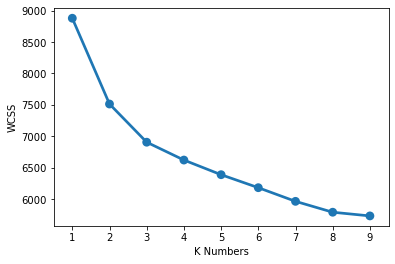

In [20]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# the Elbow method
wcss = {}
for k in range(1, 10):
    kmeans = KMeans(n_clusters= k, init= 'k-means++', random_state=2021, max_iter= 500)
    kmeans.fit(Grouped_Venues.drop('District', 1))
    wcss[k] = kmeans.inertia_
# plot the WCSS values
sns.pointplot(x = list(wcss.keys()), y = list(wcss.values()))
plt.xlabel('K Numbers')
plt.ylabel('WCSS')
plt.show()

#### I choose k = 6 as for 6 clusters there is a significant decrease in WCSS!
##### Below we continue with the clusterization:

In [21]:
# run k-means clustering
kmeans = KMeans(n_clusters=6, random_state=2021).fit(Grouped_Venues.drop('District', 1))

# check cluster labels generated for each row in the dataframe
print(kmeans.labels_)

try: 
    venues_sorted.insert(0, 'Cluster', kmeans.labels_)
except:
    pass


# merge databases to add latitude/longitude for each neighborhood
sp_merged = df.join(venues_sorted.set_index('District'), on='District')
sp_merged.dropna(subset=['Cluster'], inplace=True)
sp_merged.reset_index(drop=True, inplace=True)
sp_merged.head()

[5 0 0 4 3 3 1 3 0 5 5 0 1 1 4 0 0 0 4 5 0 4 0 0 3 0 0 1 0 0 0 1 2 0 4 4 4
 0 0 0 2 5 0 0 0 0 1 2 4 0 0 5 1 5 0 3 0 0 4 5 0 2 0 0 0 3 0 4 3 2 2 0 4 4
 4 4 0 0 0 3 0 0 1 4 0 4 5 0 1 5 4 0 4 1 0 4]


,District,latitude,longitude,Cluster,1st Most Common,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,Grajaú,-23.765150,-46.695327,0,Pizza Place,Food Truck,Brazilian Restaurant,Acai House,Bagel Shop,Ice Cream Shop,Gym / Fitness Center,Grocery Store,Moving Target,Park
1,Jardim Ângela,-23.720471,-46.771372,0,Health & Beauty Service,Hot Dog Joint,Burger Joint,Soccer Field,Mobile Phone Shop,Snack Place,Gym,Bakery,Pastelaria,Coffee Shop
2,Sapopemba,-23.605114,-46.509945,0,Bakery,Gym,Pharmacy,Farmers Market,Gym / Fitness Center,Soccer Stadium,Grocery Store,Athletics & Sports,Bookstore,Supermarket
3,Capão Redondo,-23.665079,-46.780830,0,Bakery,Pet Store,Park,Snack Place,Historic Site,Pharmacy,Brazilian Restaurant,Southern / Soul Food Restaurant,Beer Bar,Bar
4,Jardim São Luís,-23.657646,-46.730065,5,Brazilian Restaurant,Pizza Place,Buffet,Café,Gym / Fitness Center,Bakery,Coffee Shop,Restaurant,Chocolate Shop,BBQ Joint


In [22]:
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=[-23.547955,-46.634940], zoom_start=11)

# set color scheme for the clusters
x = np.arange(6)
ys = [i + x + (i*x)**2 for i in range(6)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(sp_merged['latitude'], sp_merged['longitude'], sp_merged['District'], sp_merged['Cluster']):
    label = folium.Popup(str(poi) + ' - Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Verifying the most common places by frequency of appearing in the rank (1st - 10th) in the clusters

In [23]:
a1 = sp_merged.groupby('Cluster').agg(lambda x:  x.mode().iat[0]).reset_index()# stats.mode(x)[0][0])
a1.drop(columns=['District','latitude','longitude'], inplace=True)
a1

,Cluster,1st Most Common,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
0,0,Bakery,Bakery,Bakery,Gym,Pizza Place,Pharmacy,Grocery Store,Convenience Store,Pet Store,Gym
1,1,Bar,Brazilian Restaurant,Gym / Fitness Center,Bakery,Bakery,Bar,Airport,Airport Lounge,BBQ Joint,Steakhouse
2,2,Coffee Shop,Bakery,Brazilian Restaurant,Bar,Brazilian Restaurant,Burger Joint,Art Museum,Bakery,Bakery,Brazilian Restaurant
3,3,Brazilian Restaurant,Brazilian Restaurant,Bar,Bar,Bakery,Café,Bar,Bakery,Bakery,Bakery
4,4,Bakery,Bakery,Gym,Pizza Place,Pharmacy,Burger Joint,Pharmacy,Dessert Shop,Ice Cream Shop,Convenience Store
5,5,Brazilian Restaurant,Pizza Place,Brazilian Restaurant,Restaurant,Plaza,Athletics & Sports,Market,Restaurant,Burger Joint,Arts & Crafts Store


## Below we can see the venues around Bela Vista, which is a place familiar to me, and I feel these results are very accurate!

In [24]:
sp_merged[sp_merged['District']=="Bela Vista"]

,District,latitude,longitude,Cluster,1st Most Common,2nd,3rd,4th,5th,6th,7th,8th,9th,10th
70,Bela Vista,-23.560218,-46.651418,3,Italian Restaurant,Hotel,Coffee Shop,Brazilian Restaurant,Theater,Bar,Cosmetics Shop,Japanese Restaurant,Steakhouse,Pizza Place
